In [97]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-6b/glove.6B.200d.txt
/kaggle/input/glove-6b/glove.6B.50d.txt
/kaggle/input/glove-6b/glove.6B.300d.txt
/kaggle/input/glove-6b/glove.6B.100d.txt
/kaggle/input/normalized-tweets/Tweets.parquet


# LSTM
Let's try the real NN

## Import libs

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator

## Check if CUDA is available and set the device accordingly

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Load normalized data using pandas

In [100]:
df = pd.read_parquet('/kaggle/input/normalized-tweets/Tweets.parquet')

### Look if data is Ok

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41128 entries, 1 to 41156
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Text             41128 non-null  object
 1   Sentiment        41128 non-null  object
 2   Text_Length      41128 non-null  int64 
 3   Normalized_Text  41128 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.6+ MB


In [102]:
def load_glove_embeddings(glove_file, vocab, embed_dim):
    embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings[word] = vector

    embedding_matrix = np.zeros((len(vocab), embed_dim))
    stoi = vocab.get_stoi()  # Get string-to-index mapping
    for word, idx in stoi.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return torch.tensor(embedding_matrix, dtype=torch.float)


## Tokenization and text preprocessing

In [103]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)


## Apply preprocessing

In [104]:
df['Processed_Text'] = df['Text'].apply(preprocess_text)

label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

## Split data into training, validation, and test sets

In [105]:
X_train, X_temp, y_train, y_temp = train_test_split(df['Processed_Text'], df['Sentiment'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define tokenizer and build vocabulary

In [106]:
tokenizer = get_tokenizer('spacy')

# Build vocabulary
def build_vocab(texts):
    # Tokenize texts and create an iterator
    tokenized_texts = [tokenizer(text) for text in texts]
    return build_vocab_from_iterator(tokenized_texts, specials=['<unk>', '<pad>'])

vocab = build_vocab(X_train)

# Set indices for unknown and padding tokens
vocab.set_default_index(vocab['<unk>'])

/opt/conda/lib/python3.10/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [107]:
# Load GloVe embeddings
glove_file = '/kaggle/input/glove-6b/glove.6B.300d.txt'
embed_dim = 300  # Replace with the dimension of the GloVe embeddings you are using
embedding_matrix = load_glove_embeddings(glove_file, vocab, embed_dim)


## Numericalize text function

In [108]:
def numericalize_text(text):
    return [vocab[token] for token in tokenizer(text)]

## Convert texts to sequences of indices

In [109]:
X_train_seq = [numericalize_text(text) for text in X_train]
X_test_seq = [numericalize_text(text) for text in X_test]

## Pad sequences

In [110]:
X_train_padded = pad_sequence([torch.tensor(x) for x in X_train_seq], padding_value=vocab['<pad>'], batch_first=True)
X_test_padded = pad_sequence([torch.tensor(x) for x in X_test_seq], padding_value=vocab['<pad>'], batch_first=True)

## Convert labels to tensors

In [111]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

## Custom Dataset

In [112]:
class TextDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

## Create datasets

In [113]:
train_dataset = TextDataset(X_train_padded, y_train_tensor)
test_dataset = TextDataset(X_test_padded, y_test_tensor)

## DataLoaders

In [114]:
BATCH_SIZE = 32 # 32 is the best
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

X_val_seq = [numericalize_text(text) for text in X_val]
X_val_padded = pad_sequence([torch.tensor(x) for x in X_val_seq], padding_value=vocab['<pad>'], batch_first=True)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
val_dataset = TextDataset(X_val_padded, y_val_tensor)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Define a LSTM Model with Embedding Layer

In [115]:
# class LSTMModel(nn.Module):
#     def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.5):
#         super(LSTMModel, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab['<pad>'])
#         self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
#         self.dropout = nn.Dropout(dropout_rate) # let's add a dropout layer
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         x = self.embedding(x)
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
#         out, _ = self.lstm(x, (h0, c0))
#         out = self.dropout(out[:, -1, :])  # Apply dropout to the output of the last LSTM layer
#         out = self.fc(out)
#         return out


## Define a GRU Model with Embedding Layer

In [116]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout_rate=0.5, bidirectional=True):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab['<pad>'])
        self.embedding.weight = nn.Parameter(embedding_matrix)  # Initialize with GloVe embeddings
        self.embedding.weight.requires_grad = False  # Optionally freeze embeddings
        
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        # Check if num_layers > 1 for applying dropout in GRU
        self.gru = nn.GRU(
            embed_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True, 
            dropout=dropout_rate if num_layers > 1 else 0, 
            bidirectional=bidirectional
        )


        self.dropout = nn.Dropout(dropout_rate) # Dropout layer
        self.fc = nn.Linear(hidden_dim * 2 if self.gru.bidirectional else self.hidden_dim , output_dim)


    def forward(self, x):
        x = self.embedding(x)
        # Adjust the hidden state initialization for bidirectional
        h0 = torch.zeros(self.num_layers * 2 if self.gru.bidirectional else self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        out, _ = self.gru(x, h0)

        # Adjust how to handle the output
        out = self.dropout(out[:, -1, :])  # Apply dropout
        out = self.fc(out)
        return out


## Instantiate the model

In [117]:
vocab_size = len(vocab)
hidden_dim = 64
num_layers = 4 # 1, 2, 3, 4 <- (the best choice, for GRU), 5, 6, 7, 8, 16
output_dim = len(df['Sentiment'].unique())
# Instantiate the model and move it to the device
model = GRUModel(
    vocab_size=vocab_size, 
    embed_dim=embed_dim, 
    hidden_dim=hidden_dim, 
    output_dim=output_dim, 
    num_layers=num_layers, 
    dropout_rate=0.3
).to(device)

## Calculate Class Weights

In [118]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Print class weights to verify
print("Class weights:", class_weights)

Class weights: tensor([1.4813, 1.2227, 0.8402, 1.0670, 0.7248], device='cuda:0')


## Training setup

In [119]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [120]:
# Update loss function to use class weights
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [121]:
# Update loss function to use class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.NAdam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [122]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.RMSprop(model.parameters(), lr=0.01)

In [123]:
# criterion = nn.BCEWithLogitsLoss()

## Training loop with validation

In [124]:
# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 40
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()
            _, predicted_labels = torch.max(predictions, 1)
            correct += (predicted_labels == y_batch).sum().item()
            total += y_batch.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    scheduler.step(val_loss)
    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    print(
        f"Epoch [{epoch + 1} / {num_epochs}], \
        Training Loss: {avg_loss:.4f}, \
        Validation Loss: {avg_val_loss:.4f}, \
        Validation Accuracy: {val_accuracy:.4f}"
    )

    # Early stopping check
    if epochs_no_improve == patience:
        print("Early stopping triggered")
        break

Epoch [1 / 40],         Training Loss: 1.2236,         Validation Loss: 1.0401,         Validation Accuracy: 0.5481
Epoch [2 / 40],         Training Loss: 0.9039,         Validation Loss: 0.9169,         Validation Accuracy: 0.6264
Epoch [3 / 40],         Training Loss: 0.7880,         Validation Loss: 0.8568,         Validation Accuracy: 0.6520
Epoch [4 / 40],         Training Loss: 0.6947,         Validation Loss: 0.8257,         Validation Accuracy: 0.6839
Epoch [5 / 40],         Training Loss: 0.6173,         Validation Loss: 0.8441,         Validation Accuracy: 0.6734
Epoch [6 / 40],         Training Loss: 0.5520,         Validation Loss: 0.8442,         Validation Accuracy: 0.6837
Epoch [7 / 40],         Training Loss: 0.4874,         Validation Loss: 0.9459,         Validation Accuracy: 0.6606
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch [8 / 40],         Training Loss: 0.4351,         Validation Loss: 0.9523,         Validation Accuracy: 0.6849
Epoch [9 /

### Plot the results

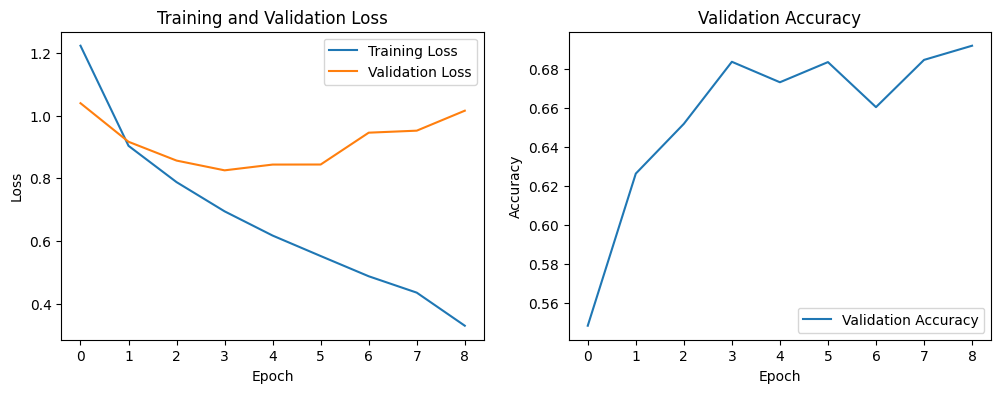

In [125]:
# Plotting the training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Evaluation on the test set

In [126]:
model.eval()
test_predictions = []
test_true_labels = []
test_probabilities = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        predictions = model(X_batch)
        probabilities = torch.softmax(predictions, dim=1)
        _, predicted_labels = torch.max(probabilities, 1)
        
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_true_labels.extend(y_batch.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())

## Metrics

In [127]:
# Convert to numpy arrays for scoring
test_predictions = np.array(test_predictions)
test_true_labels = np.array(test_true_labels)
test_probabilities = np.array(test_probabilities)

### Calculate ROC AUC and F1 Score
We've choosen F1 and ROC auc because we have imbalanced labels

In [128]:
roc_auc = roc_auc_score(test_true_labels, test_probabilities, multi_class='ovr', average='macro')
f1 = f1_score(test_true_labels, test_predictions, average='macro')

print(f"Test ROC AUC: {roc_auc:.4f}, Test F1 Score: {f1:.4f}")

Test ROC AUC: 0.9092, Test F1 Score: 0.7062


LSTM => 0.59

GRU => 0.70 

# Conclusion

Model Architecture Changes:

    Switching from LSTM to GRU resulted in a 5% improvement in F1-score. This suggests that GRU was more effective for our specific text classification task.
    Incorporating GloVe embeddings further enhanced the model's performance by an additional 5%. This indicates the effectiveness of pre-trained embeddings in capturing semantic relationships in the text.

Optimization Adjustments:

    Changing the optimizer from Adam to NAdam yielded a 1-2% increase in performance. This highlights the benefit of NAdam's adaptive learning rate strategy in our context.
    The optimal learning rate was identified as 0.001. It is noted that lower learning rates worked well with the LSTM model but were less effective with the GRU model.

Regularization Techniques:

    Applying dropout rates higher than 0.3 adversely affected the model's training. This suggests an optimal dropout rate of around 0.3 for balancing between model complexity and overfitting.
    With a simple GRU model, the best performance was observed with 6 layers. However, for the Bidirectional GRU model, reducing the number of layers to 4 and decreasing the hidden layer size from 256 to 64 proved more effective. This adjustment likely helped in reducing overfitting and computational complexity.

Additional Techniques and Observations:

    The introduction of weight decay did not yield positive results, indicating that it might not be necessary for this particular model configuration.
    The implementation of early stopping and the ReduceLROnPlateau method helped in preventing overfitting and optimizing the learning rate dynamically during training.

Overall, these adjustments and optimizations have led to a more effective and efficient model for our multi-label text classification task, demonstrating the importance of tailoring the model architecture and training process to the specific characteristics of the dataset and task at hand.